In [49]:
import numpy as np
#%load_ext cudf.pandas
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig

In [50]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))


True
0
NVIDIA GeForce RTX 4090 Laptop GPU


In [51]:
df1 = pd.read_csv('engine_system.csv')

In [52]:
df1.head()

,Unnamed: 0,61443-91,61444-512,61444-513
0,3,58.8,43.0,45.0
1,33,0.0,0.0,0.0
2,63,39.2,39.0,37.0
3,93,47.6,0.0,38.0
4,123,53.6,15.0,15.0


In [53]:
df1.drop(['Unnamed: 0'], axis=1, inplace=True)
df1.reset_index(inplace=True)

In [54]:
df1.shape

(126729, 4)

In [55]:
seq_len = 512 
model = DGAN(DGANConfig(
    max_sequence_len=seq_len,
    sample_len=1,
    feature_num_layers=2,                       #was 4
    feature_num_units=100,                      #was 50
    feature_noise_dim=30,
    batch_size=3000,
    epochs=3000,  # For real data sets, 100-1000 epochs is typical     #was 5k
))

model.train_dataframe(
    df1,
    df_style= "long",
    feature_columns=['61443-91', '61444-512', '61444-513'],
)

2024-04-24 10:24:24,966 : MainThread : WARNING : Example ID column not provided, DGAN will autosplit dataset into sequences of size 512!
2024-04-24 10:24:24,995 : MainThread : INFO : epoch: 0
2024-04-24 10:24:25,903 : MainThread : INFO : epoch: 1
2024-04-24 10:24:25,984 : MainThread : INFO : epoch: 2
2024-04-24 10:24:26,059 : MainThread : INFO : epoch: 3
2024-04-24 10:24:26,133 : MainThread : INFO : epoch: 4
2024-04-24 10:24:26,198 : MainThread : INFO : epoch: 5
2024-04-24 10:24:26,263 : MainThread : INFO : epoch: 6
2024-04-24 10:24:26,325 : MainThread : INFO : epoch: 7
2024-04-24 10:24:26,387 : MainThread : INFO : epoch: 8
2024-04-24 10:24:26,449 : MainThread : INFO : epoch: 9
2024-04-24 10:24:26,515 : MainThread : INFO : epoch: 10
2024-04-24 10:24:26,573 : MainThread : INFO : epoch: 11
2024-04-24 10:24:26,633 : MainThread : INFO : epoch: 12
2024-04-24 10:24:26,695 : MainThread : INFO : epoch: 13
2024-04-24 10:24:26,755 : MainThread : INFO : epoch: 14
2024-04-24 10:24:26,814 : MainThr

In [56]:
synthetic_df['61443-91']

0         48.593281
1         39.681309
2         37.981506
3         38.317348
4         39.177891
            ...    
125995    43.027485
125996    42.962627
125997    42.999924
125998    42.864910
125999    42.979908
Name: 61443-91, Length: 126000, dtype: float32

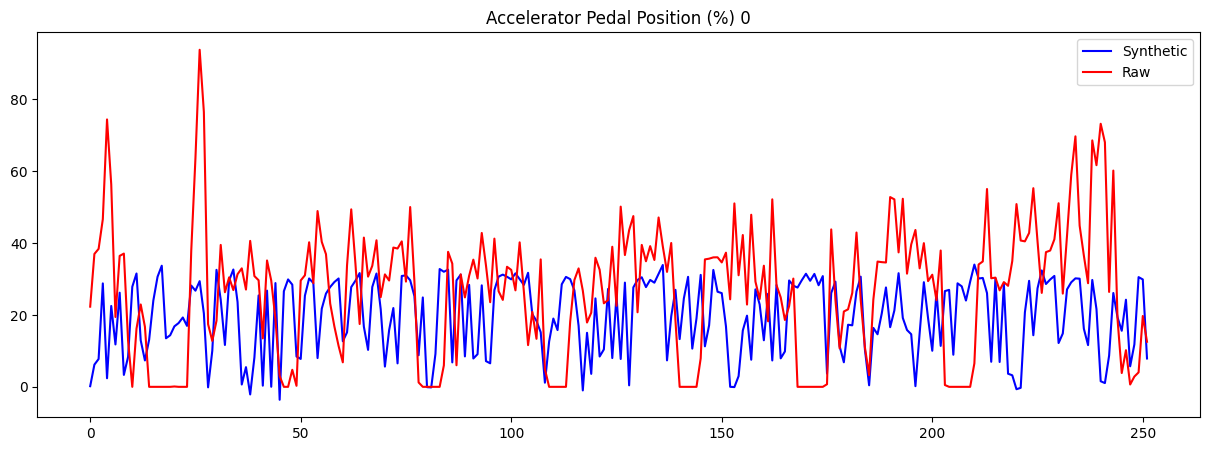

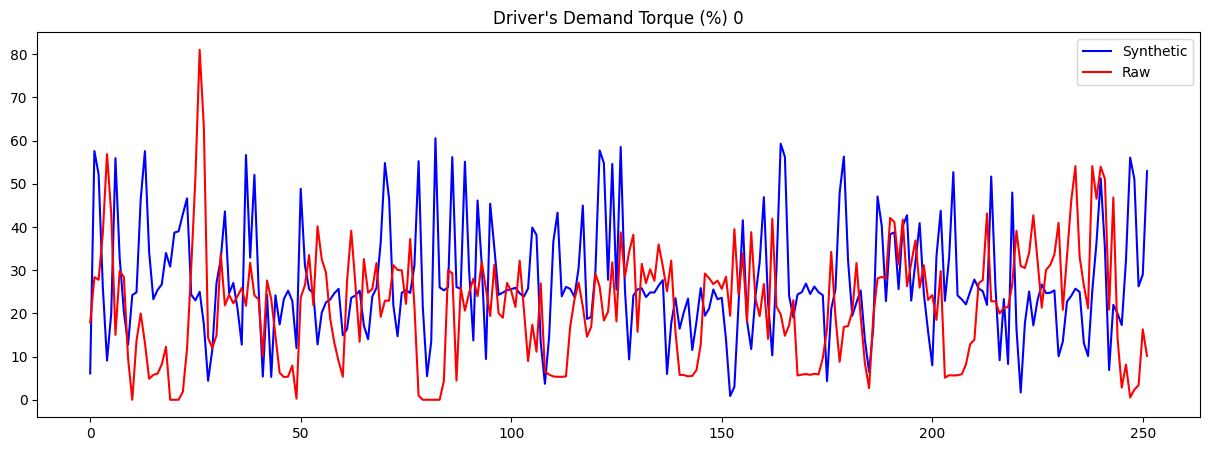

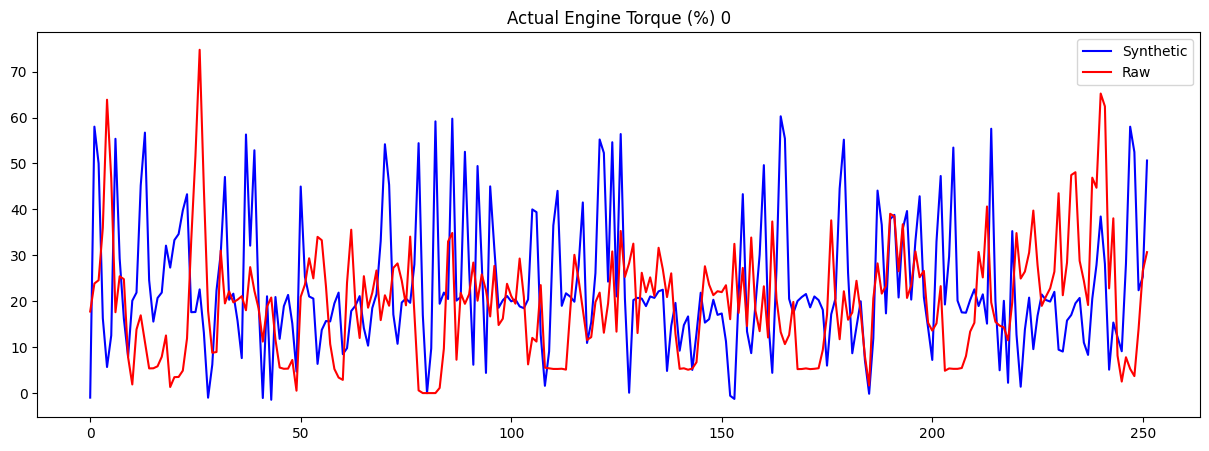

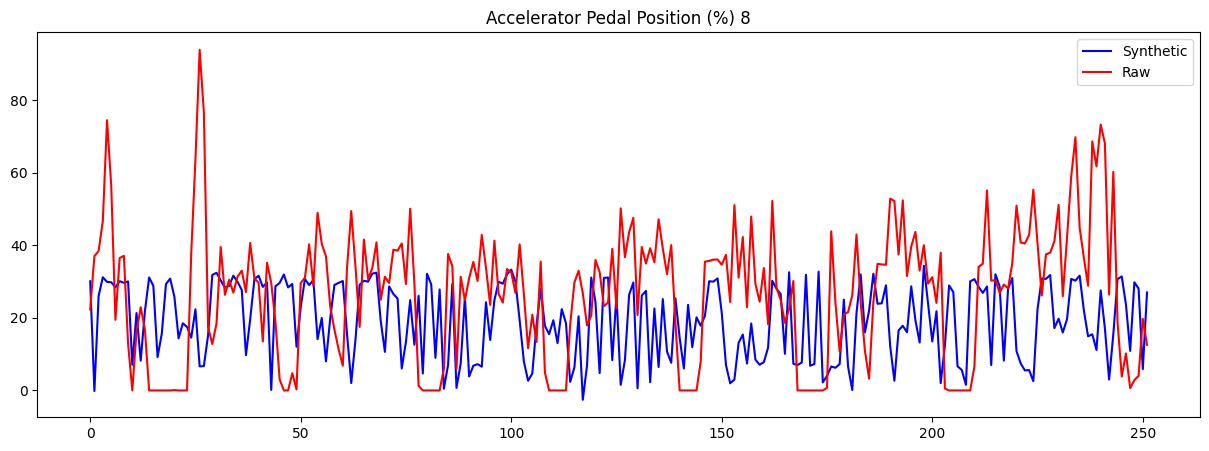

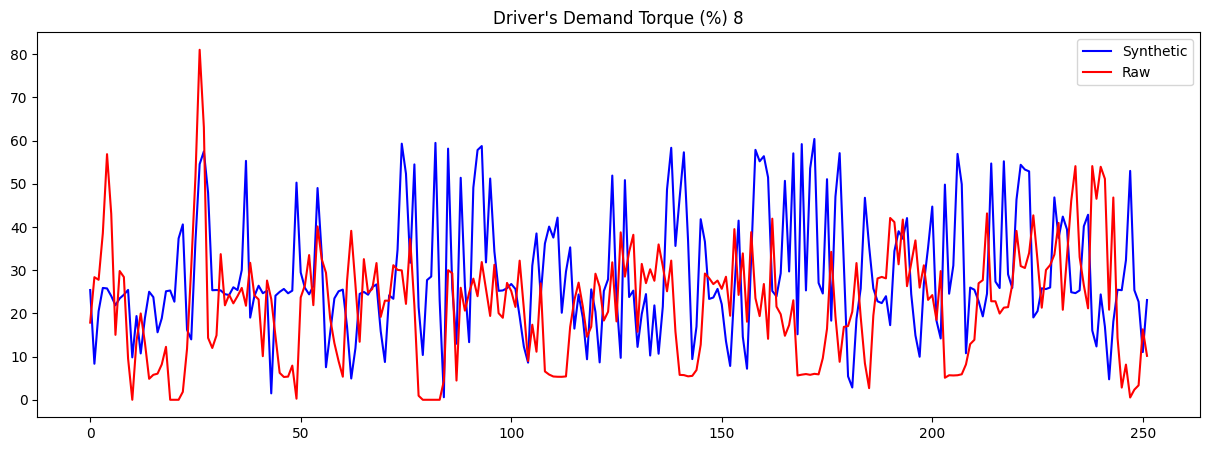

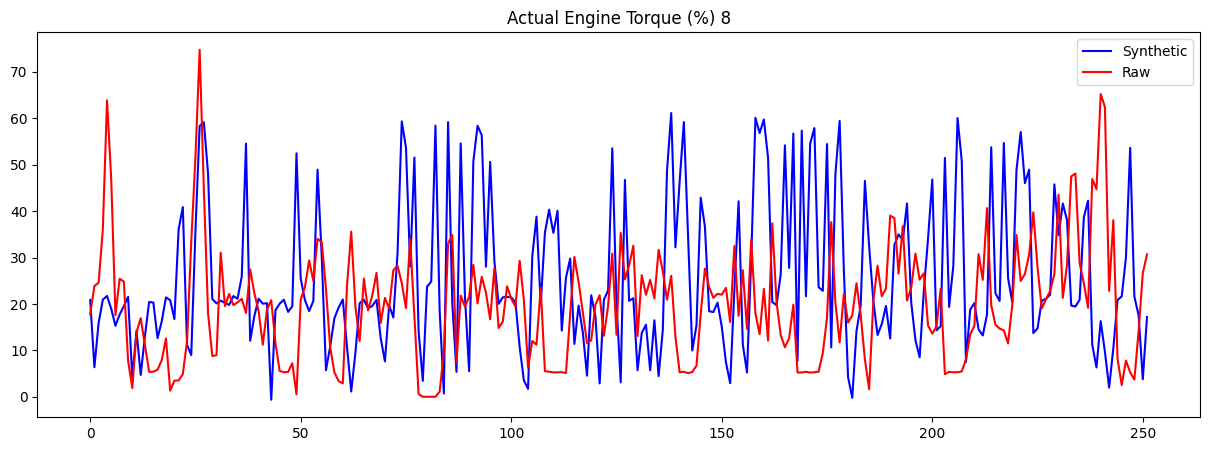

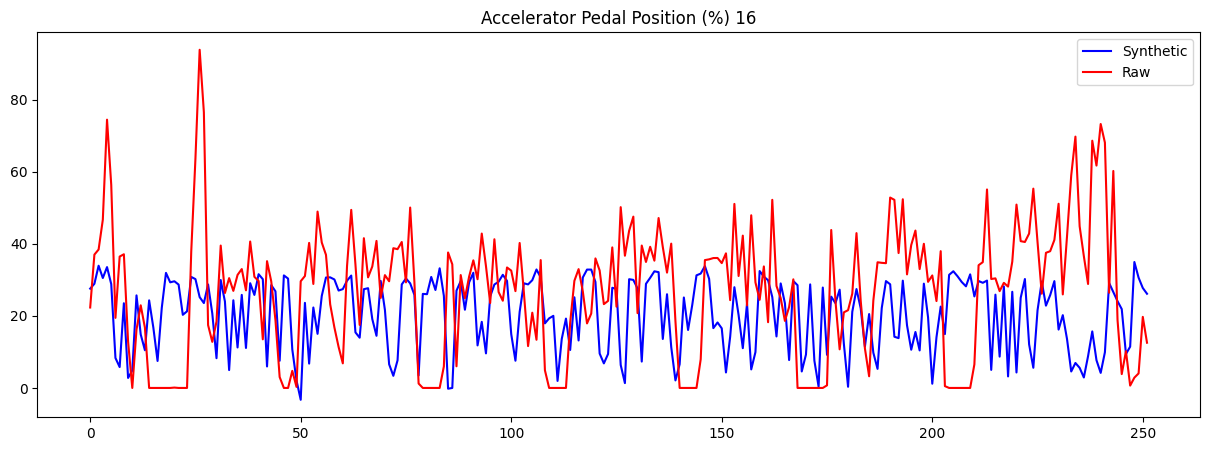

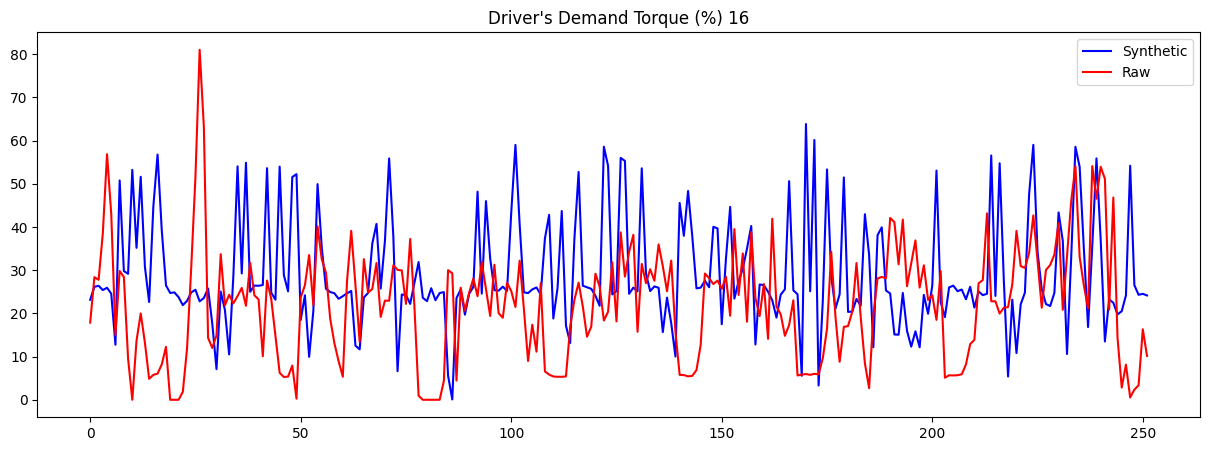

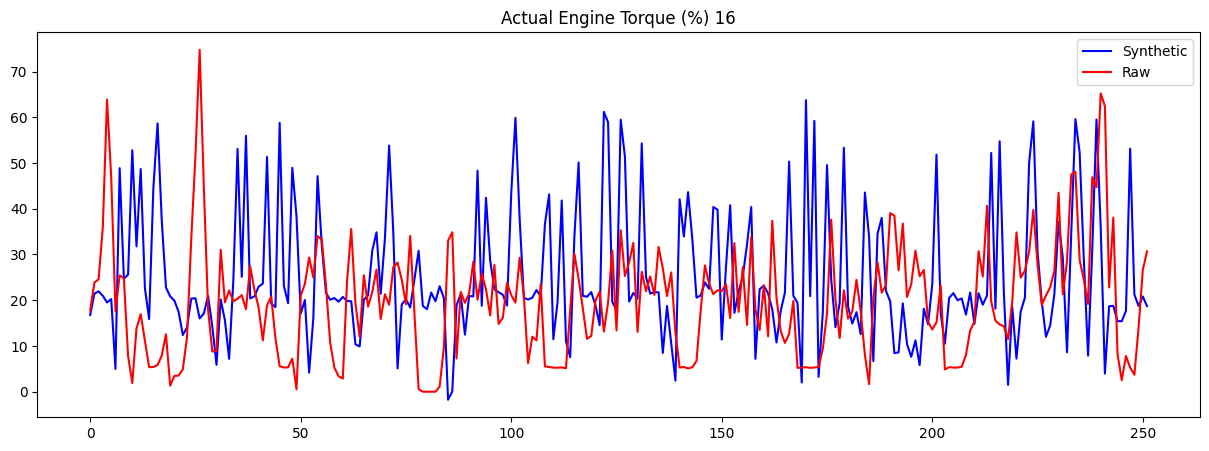

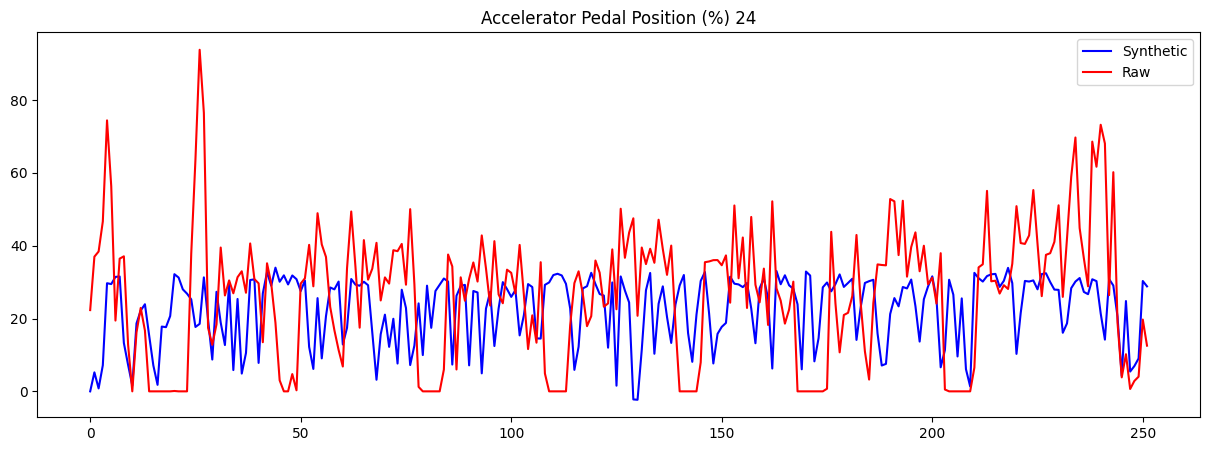

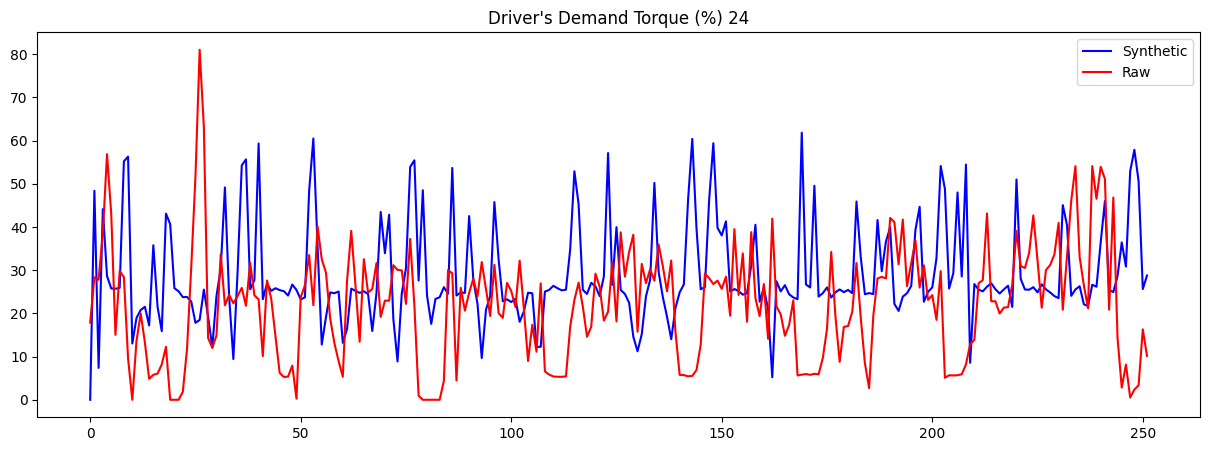

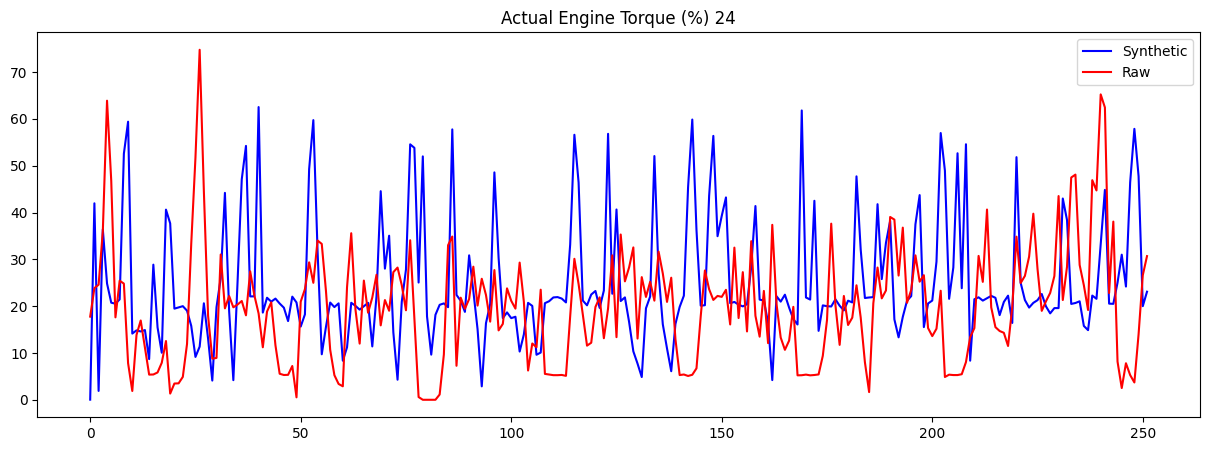

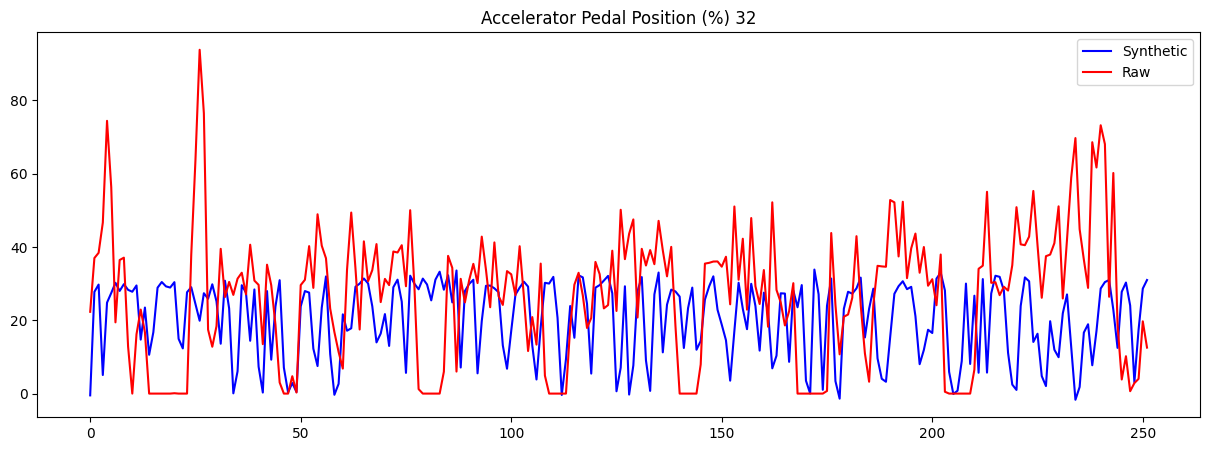

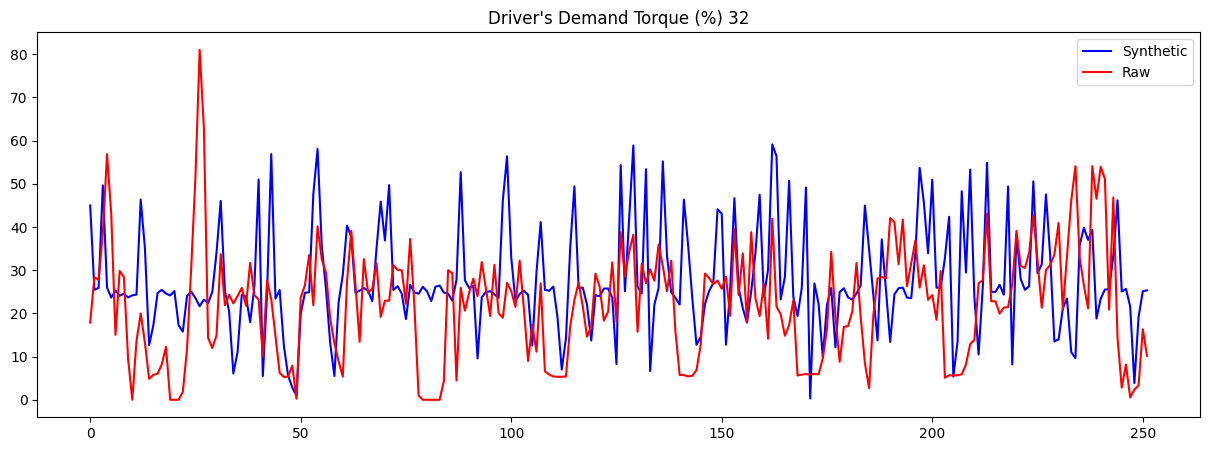

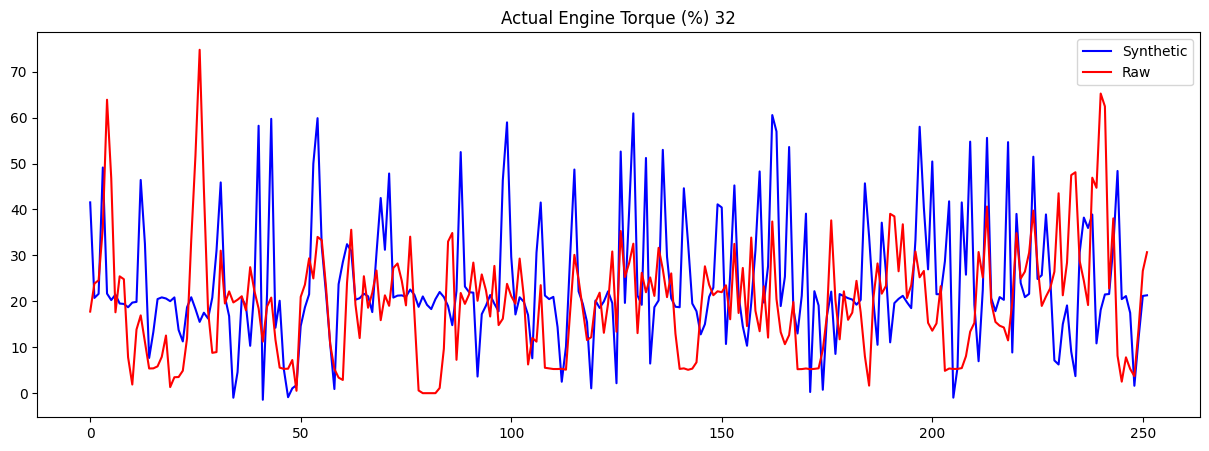

In [57]:
df = df1.copy()
path = 'Generated_engine_sys_data'
for i in range(40):
    name = path+"\\synthetic_engine_"+str(i)+".csv"
    

    # Generate synthetic data
    synthetic_df = model.generate_dataframe(int(len(df)/seq_len))

    synthetic_df
    w = 500
    if i % 8 == 0:
        plt.figure(figsize=(15,5))
        v1 = synthetic_df['61443-91'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(df1)/w))]]/w
        v2 = df1['61443-91'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(df1)/w))]]/w
        plt.title('Accelerator Pedal Position (%) ' + str(i))
        plt.plot(np.arange(len(v1)),v1, c='b', label='Synthetic')
        plt.plot(np.arange(len(v1)),v2, c='r', label = 'Raw')
        plt.legend()
        plt.figure(figsize=(15,5))
        v1 = synthetic_df['61444-512'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(df1)/w))]]/w
        v2 = df1['61444-512'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(df1)/w))]]/w
        plt.title('Driver\'s Demand Torque (%) '  + str(i))
        plt.plot(np.arange(len(v1)),v1, c='b', label='Synthetic')
        plt.plot(np.arange(len(v1)),v2, c='r', label = 'Raw')
        plt.legend()
        plt.figure(figsize=(15,5))
        v1 = synthetic_df['61444-513'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(df1)/w))]]/w
        v2 = df1['61444-513'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(df1)/w))]]/w
        plt.title('Actual Engine Torque (%) ' + str(i))
        plt.plot(np.arange(len(v1)),v1, c='b', label='Synthetic')
        plt.plot(np.arange(len(v1)),v2, c='r', label = 'Raw')
        plt.legend()

    synthetic_df.to_csv(name)
    del synthetic_df
plt.show()

In [58]:
sdf = pd.read_csv(r'Generated_engine_sys_data\synthetic_engine_32.csv')
sdf.drop(['Unnamed: 0', 'example_id'], axis=1, inplace=True)

In [59]:
sdf.head()

,61443-91,61444-512,61444-513
0,33.321865,34.059093,26.726180
1,31.820866,36.163494,27.658075
2,25.639307,40.415943,31.060871
3,16.296429,43.901200,35.344906
4,10.799103,46.850315,38.764313


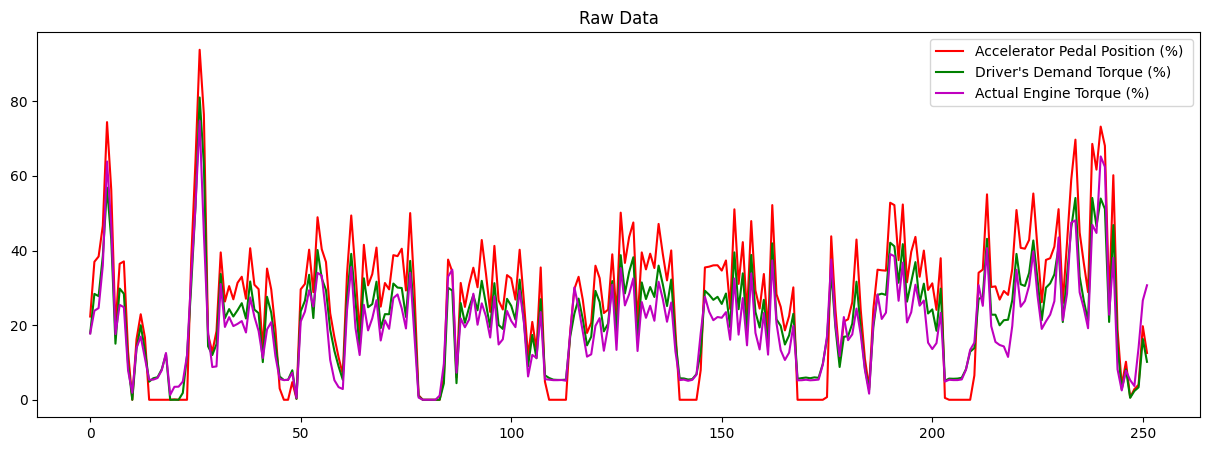

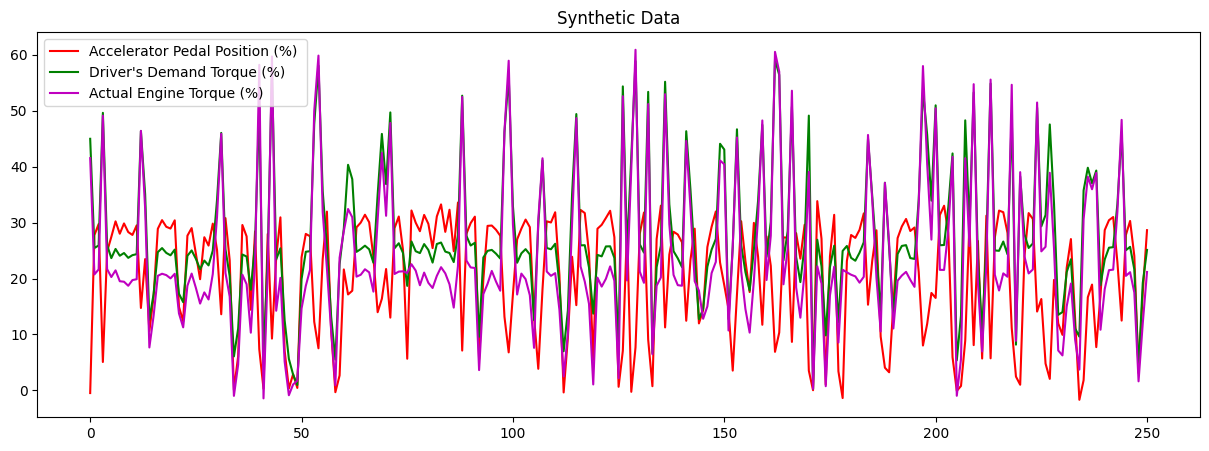

In [60]:
w=500
plt.figure(figsize=(15,5))
v2 = df1['61443-91'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(df1)/w))]]/w
v3 = df1['61444-512'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(df1)/w))]]/w
v4 = df1['61444-513'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(df1)/w))]]/w
plt.title('Raw Data')
plt.plot(np.arange(len(v2)),v2, c='r', label='Accelerator Pedal Position (%) ')
plt.plot(np.arange(len(v2)),v3, c='g', label='Driver\'s Demand Torque (%) ')
plt.plot(np.arange(len(v2)),v4, c='m', label='Actual Engine Torque (%) ')
plt.legend()
plt.figure(figsize=(15,5))
v2 = sdf['61443-91'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(sdf)/w))]]/w
v3 = sdf['61444-512'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(sdf)/w))]]/w
v4 = sdf['61444-513'].rolling(min_periods=1, window=w).sum()[[i*w for i in range(1, int(len(sdf)/w))]]/w
plt.title('Synthetic Data')
plt.plot(np.arange(len(v2)),v2, c='r', label='Accelerator Pedal Position (%) ')
plt.plot(np.arange(len(v2)),v3, c='g', label='Driver\'s Demand Torque (%) ')
plt.plot(np.arange(len(v2)),v4, c='m', label='Actual Engine Torque (%) ')
plt.legend()
plt.show()


In [61]:
df1.corr()

,index,61443-91,61444-512,61444-513
index,1.000000,0.064144,0.055706,0.066676
61443-91,0.064144,1.000000,0.939054,0.813930
61444-512,0.055706,0.939054,1.000000,0.823126
61444-513,0.066676,0.813930,0.823126,1.000000


In [62]:
sdf.corr()

,61443-91,61444-512,61444-513
61443-91,1.000000,-0.120510,-0.181423
61444-512,-0.120510,1.000000,0.982937
61444-513,-0.181423,0.982937,1.000000


In [63]:
df1.describe()

,index,61443-91,61444-512,61444-513
count,126729.000000,126729.000000,126729.000000,126729.000000
mean,63364.000000,26.590432,21.989182,19.757104
std,36583.655469,31.387741,25.932387,22.410236
min,0.000000,0.000000,0.000000,0.000000
25%,31682.000000,0.000000,0.000000,4.000000
50%,63364.000000,0.000000,7.000000,6.000000
75%,95046.000000,54.800000,43.000000,36.000000
max,126728.000000,100.000000,99.000000,95.000000


In [64]:
sdf.describe()

,61443-91,61444-512,61444-513
count,126464.000000,1.264640e+05,126464.000000
mean,20.416461,2.761291e+01,23.872968
std,12.446077,1.480839e+01,16.777437
min,-3.374196,1.106787e-28,-3.802033
25%,6.945479,2.322024e+01,18.248514
50%,27.696957,2.496779e+01,20.434945
75%,30.137786,2.658807e+01,22.248932
max,56.586098,6.671569e+01,64.418280


In [65]:
def moving_avg(x, N=1000):          #function to compute moving average
    return np.convolve(x, np.ones((N,))/N, mode='valid')

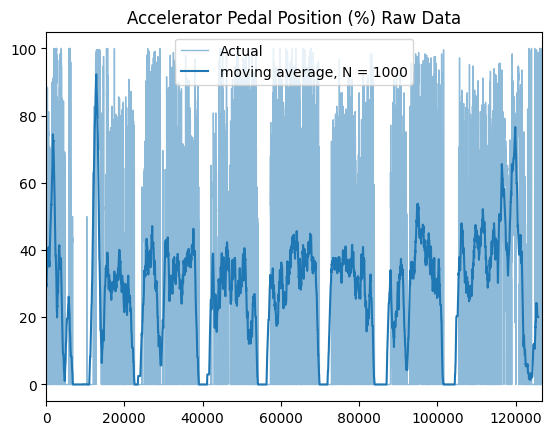

In [66]:

plt.plot(df1['61443-91'], linewidth = 1, alpha = 0.5, label = 'Actual')
plt.plot(moving_avg(df1['61443-91'], 1000), 'C0', label = 'moving average, N = 1000')
plt.xlim(0,len(df1['61443-91']))
plt.title('Accelerator Pedal Position (%) Raw Data')
plt.legend()
plt.show()


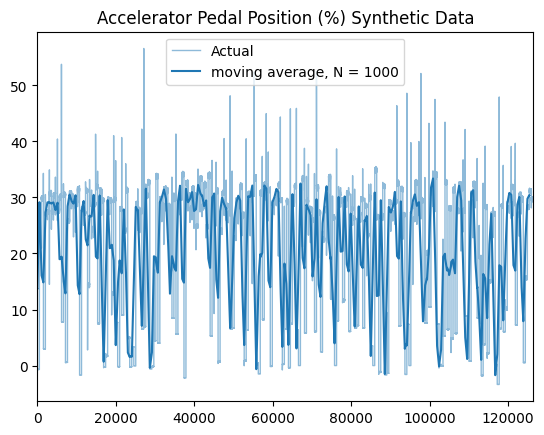

In [67]:
plt.plot(sdf['61443-91'], linewidth = 1, alpha = 0.5, label = 'Actual')
plt.plot(moving_avg(sdf['61443-91'], 1000), 'C0', label = 'moving average, N = 1000')
plt.xlim(0,len(sdf['61443-91']))
plt.title('Accelerator Pedal Position (%) Synthetic Data')
plt.legend()
plt.show()

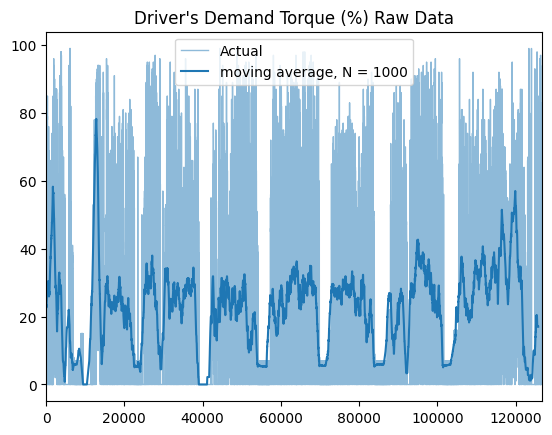

In [68]:
plt.plot(df1['61444-512'], linewidth = 1, alpha = 0.5, label = 'Actual')
plt.plot(moving_avg(df1['61444-512'], 1000), 'C0', label = 'moving average, N = 1000')
plt.xlim(0,len(df1['61444-512']))
plt.title('Driver\'s Demand Torque (%) Raw Data')
plt.legend()
plt.show()

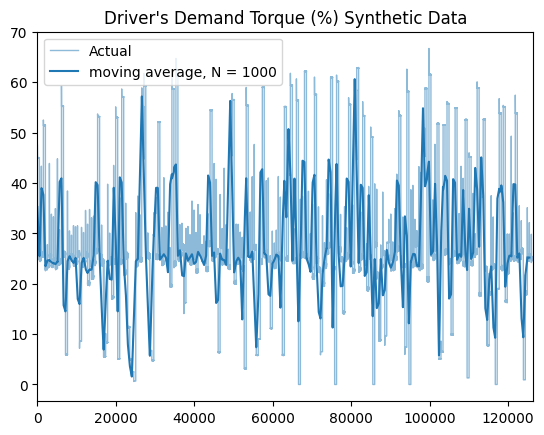

In [69]:
plt.plot(sdf['61444-512'], linewidth = 1, alpha = 0.5, label = 'Actual')
plt.plot(moving_avg(sdf['61444-512'], 1000), 'C0', label = 'moving average, N = 1000')
plt.xlim(0,len(sdf['61444-512']))
plt.title('Driver\'s Demand Torque (%) Synthetic Data')
plt.legend()
plt.show()

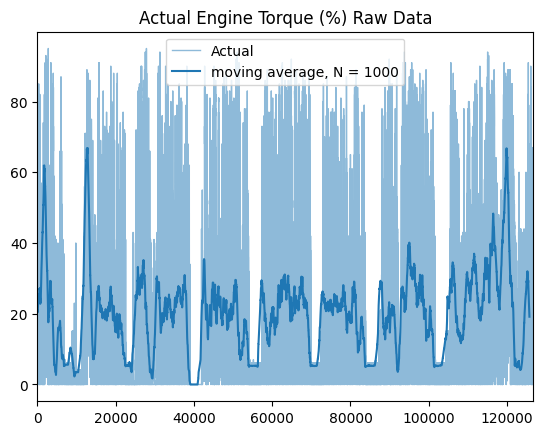

In [70]:
plt.plot(df1['61444-513'], linewidth = 1, alpha = 0.5, label = 'Actual')
plt.plot(moving_avg(df1['61444-513'], 1000), 'C0', label = 'moving average, N = 1000')
plt.xlim(0,len(df1['61444-513']))
plt.title('Actual Engine Torque (%) Raw Data')
plt.legend()
plt.show()

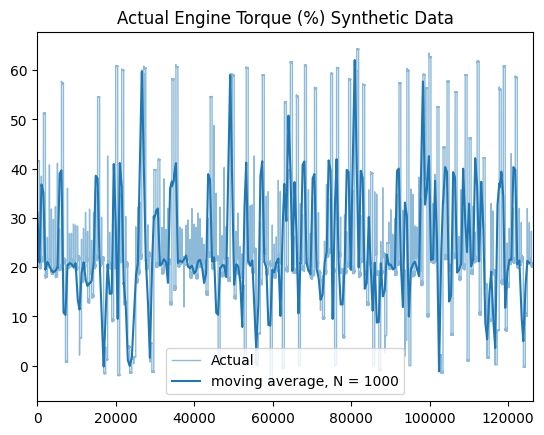

In [71]:
plt.plot(sdf['61444-513'], linewidth = 1, alpha = 0.5, label = 'Actual')
plt.plot(moving_avg(sdf['61444-513'], 1000), 'C0', label = 'moving average, N = 1000')
plt.xlim(0,len(sdf['61444-513']))
plt.title('Actual Engine Torque (%) Synthetic Data')
plt.legend()
plt.show()

In [72]:
import winsound
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)